In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/work/scripts/util')
from output import load_trsc_dataframe, build_full_datetimeindex

In [2]:
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import seaborn as sns
import xarray as xr
from output import load_trsc_dataframe
import seaborn as sns

In [3]:
cell_y_coord=0
cell_x_coord=0

In [4]:
#model run level information

data_paths=['/data/workflows/BONA-black-spruce-fire-control/output/',
            '/data/workflows/BONA-black-spruce-fire-1930/output/',
            '/data/workflows/BONA-black-spruce-fire-1960/output/',
            '/data/workflows/BONA-black-spruce-fire-1990/output/',
            '/data/workflows/BONA-black-spruce-fire-2030/output/',
            '/data/workflows/BONA-birch-fire-control/output/',
            '/data/workflows/BONA-birch-fire-1930/output/',
            '/data/workflows/BONA-birch-fire-1960/output/',
            '/data/workflows/BONA-birch-fire-1990/output/',
            '/data/workflows/BONA-birch-fire-2030/output/'
           ]
#data_paths=['/data/workflows/BONA-black-spruce-fire-control-nfix/output/',
#            '/data/workflows/BONA-black-spruce-fire-1930-nfix/output/',
#            '/data/workflows/BONA-black-spruce-fire-1960-nfix/output/',
#            '/data/workflows/BONA-black-spruce-fire-1990-nfix/output/',
#            '/data/workflows/BONA-birch-fire-control-nfix/output/',
#            '/data/workflows/BONA-birch-fire-1930-nfix/output/',
#            '/data/workflows/BONA-birch-fire-1960-nfix/output/',
#            '/data/workflows/BONA-birch-fire-1990-nfix/output/'
#           ]

#data_paths=['/data/workflows/BONA-black-spruce-fire-control-rhmoist/output/',
#            '/data/workflows/BONA-black-spruce-fire-1930-rhmoist/output/',
#            '/data/workflows/BONA-black-spruce-fire-1960-rhmoist/output/',
#            '/data/workflows/BONA-black-spruce-fire-1990-rhmoist/output/',
#            '/data/workflows/BONA-birch-fire-control-rhmoist/output/',
#            '/data/workflows/BONA-birch-fire-1930-rhmoist/output/',
#           '/data/workflows/BONA-birch-fire-1960-rhmoist/output/',
#            '/data/workflows/BONA-birch-fire-1990-rhmoist/output/'
#           ]

exp = ['control', 
       'burn_1930', 
       'burn_1960', 
       'burn_1990',
       'burn_2030',
       'control', 
       'burn_1930', 
       'burn_1960', 
       'burn_1990',
       'burn_2030']

cmt = ['black_spruce', 
       'black_spruce', 
       'black_spruce', 
       'black_spruce',
       'black_spruce',
       'birch', 
       'birch', 
       'birch', 
       'birch',
       'birch']

pfts = {'black_spruce': ['Black Spruce', 'Decid. Shrub', 'Evr. Shrub', 'Moss', 'Lichen'],
        'birch': ['White Spruce', 'Decid. Shrub', 'Birch', 'Moss', 'Evr. Shrub']}

burn_year = [1900, 
             1930, 
             1960, 
             1990,
             2030,
             1900, 
             1930, 
             1960, 
             1990,
             2030]

#variable-level information, assuming same outputs from each model run
var_list = ['GPP', 
            'NPP', 
            'RH', 
            'RG', 
            'RM',
            'LTRFALC',
            'SHLWC',
            'VEGC',
            'DEEPC',
            'MINEC',
            'AVLN',
            'ORGN',
            'ALD',
            'SHLWDZ',
            'DEEPDZ',
            'WATERTAB',
            'EET',
            'PET',
            'SOMA',
            'SOMCR',
            'SOMPR',
            'SOMRAWC',
            'BURNVEG2AIRC',
            'BURNSOIC',
            'GROWSTART',
            'GROWEND',
            'YSD'
           ]

timeres = ['monthly', 
           'monthly', 
           'monthly', 
           'monthly',
           'monthly', 
           'monthly',
           'monthly',
           'monthly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly'
            ]

year_agg = ['sum', 
               'sum', 
               'sum', 
               'sum', 
               'sum',
               'sum',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'sum', 
               'sum',
               'sum', 
               'sum',
               'sum'
                ]

detail = ['cmt', 
          'cmt', 
          'cmt', 
          'cmt', 
          'cmt',
          'cmt',
          'cmt',
          'pft',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt'
         ]

In [5]:
def get_monthly_data(data_path, var, cell_y_coord=0, cell_x_coord=0, year_agg='mean'):
    
    df_monthly = load_trsc_dataframe(var=var, timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=data_path, stages=['tr', 'sc'])[0].reset_index()
    df_monthly.columns = ['time', var]
    df_monthly['time'] = pd.to_datetime(df_monthly['time'])
    df_monthly['year'] = df_monthly['time'].dt.year

    if year_agg == 'mean':
        df_yearly = df_monthly[['year', var]].groupby(by='year').mean()
        
    if year_agg == 'sum':
        df_yearly = df_monthly[['year', var]].groupby(by='year').sum()
    
    return df_monthly, df_yearly

In [6]:
def get_yearly_data(data_path, var, cell_y_coord=0, cell_x_coord=0):
    
    df_yearly = load_trsc_dataframe(var=var, timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=data_path, stages=['tr', 'sc'])[0].reset_index()
    df_yearly.columns = ['time', var]
    df_yearly['time'] = pd.to_datetime(df_yearly['time'])
    df_yearly['year'] = df_yearly['time'].dt.year
    
    return df_yearly

In [7]:
def get_monthly_data_part(data_path, var, pfts, cell_y_coord=0, cell_x_coord=0, year_agg='mean'):
    
    #df_monthly = xr.open_dataset(data_path+var+'_monthly_tr.nc')
    #df_monthly = df_monthly.convert_calendar('standard', use_cftime=False, align_on='date')
    #df_monthly = df_monthly.to_dataframe().reset_index()
    
    df_monthly = load_trsc_dataframe(var=var, timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=data_path, stages=['tr', 'sc'])[0].reset_index()
    #df_monthly = df_monthly.loc[(df_monthly['y']==cell_y_coord) & (df_monthly['x']==cell_x_coord) & (df_monthly['pft']<5)]
    print(df_monthly)
    df_monthly = df_monthly[['index', 0, 1, 2, 3, 4]]
    df_monthly = df_monthly[['time','pft', 'pftpart', var]]
    df_monthly['year'] = df_monthly['time'].dt.year
    
    
    
    if year_agg== 'mean':
        df_yearly = df_monthly.groupby(by=['year', 'pft', 'pftpart']).mean().reset_index()
    
    if year_agg== 'sum':
        df_yearly = df_monthly.groupby(by=['year', 'pft', 'pftpart']).sum().reset_index()

    return df_monthly, df_yearly

In [8]:
def get_monthly_data_pft(data_path, var, pfts, cell_y_coord=0, cell_x_coord=0, year_agg='mean'):
    
    df_monthly = load_trsc_dataframe(var=var, timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=data_path, stages=['tr', 'sc'])[0].reset_index()
    
    df_monthly = df_monthly[['index', 0, 1, 2, 3, 4]]
    df_monthly.columns = ['time']+pfts
    df_monthly['time'] = pd.to_datetime(df_monthly['time'])
    df_monthly['year'] = df_monthly['time'].dt.year
    
    if year_agg== 'mean':
        df_yearly = df_monthly[['year']+pfts].groupby(by='year').mean().reset_index()
    
    if year_agg== 'sum':
        df_yearly = df_monthly[['year']+pfts].groupby(by='year').sum().reset_index()

    return df_monthly, df_yearly

In [9]:
depthlist = [0.08, 0.1, 0.2, 0.3]

def get_lwclayer_tlayer(depthlist, run_dir, var):
    
    reference_date_2016 = pd.Timestamp('2016-01-01')
    reference_date_2022 = pd.Timestamp('2022-01-01')
    delta = (reference_date_2022 - reference_date_2016)
    
    ### read the netcdf output files and compute year from the time dimension
    data = xr.open_dataset(f'{run_dir}/output/{var}_yearly_tr.nc')
    data = data.to_dataframe()
    data = data.reset_index()
    
    data_sc=xr.open_dataset(f'{run_dir}/output/{var}_yearly_sc.nc')
    data_sc = data_sc.to_dataframe()
    data_sc = data_sc.reset_index()
    data_sc['time'] = data_sc['time'] + delta
    data=pd.concat([data, data_sc], axis=0)
    
    
    
    data = data.reset_index(drop=True)

    data.dtypes
    data['time'] = data['time'].astype('|S80')
    data['time'] = data['time'].astype('|datetime64[ns]')
    data['month'] = data['time'].dt.month
    data['year'] = data['time'].dt.year
    data = data.sort_values(['time','x','y','layer'])


    ### read the netcdf output files on soil structure and compute year from the time dimension
    dz = xr.open_dataset(f'{run_dir}/output/LAYERDZ_yearly_tr.nc')
    dz = dz.to_dataframe()
    dz= dz.reset_index()
    
    dz_sc = xr.open_dataset(f'{run_dir}/output/LAYERDZ_yearly_sc.nc')
    dz_sc = dz_sc.to_dataframe()
    dz_sc= dz_sc.reset_index()
    dz_sc['time'] = dz_sc['time'] + delta
    
    dz=pd.concat([dz, dz_sc])

    # Assign the new time coordinate back to the dataset
    dz = dz.reset_index()
    
    dz.reset_index(inplace=True)
    dz.dtypes
    dz['time'] = dz['time'].astype('|S80')
    dz['time'] = dz['time'].astype('|datetime64[ns]')
    dz['month'] = dz['time'].dt.month
    dz['year'] = dz['time'].dt.year
    dz = dz.sort_values(['time','x','y','layer'])

    ### read the netcdf output files on soil structure and compute year from the time dimension
    lt = xr.open_dataset(f'{run_dir}/output/LAYERTYPE_yearly_tr.nc')
    lt = lt.to_dataframe()
    lt = lt.reset_index()
    
    lt_sc = xr.open_dataset(f'{run_dir}/output/LAYERTYPE_yearly_sc.nc')
    lt_sc = lt_sc.to_dataframe()
    lt_sc = lt_sc.reset_index()
    lt_sc['time'] = lt_sc['time'] + delta
    
    lt=pd.concat([lt, lt_sc], axis=0)
    
    
    lt = lt.reset_index(drop=True)
    
    lt.reset_index(inplace=True)
    lt.dtypes
    lt['time'] = lt['time'].astype('|S80')
    lt['time'] = lt['time'].astype('|datetime64[ns]')
    #lt['month'] = lt['time'].dt.month
    lt['year'] = lt['time'].dt.year
    lt = lt.sort_values(['time','x','y','layer'])
    dz=pd.merge(dz, lt[['LAYERTYPE', 'time', 'x', 'y', 'layer']], on=['time','x','y','layer'])


    ### compute the depth of the bottom of every layers
    dz['z'] = dz.groupby(['time','x','y'])['LAYERDZ'].cumsum(axis=0)
    
    ### loop through the list of depths of reference to compute the soil variable at that depth via linear interpolation
    stdz = []
    for i in range(len(depthlist)):
        dpth = depthlist[i]
        print("depth:", dpth,"m")
        # extract the top and bottom layers the closest to the depth of reference
        dz['diff'] = dz['z']-float(dpth)
        top = dz.loc[dz[(dz['diff'] <= 0)].groupby(['time','x','y'])['diff'].idxmax()]
        bot = dz.loc[dz[(dz['diff'] >= 0)].groupby(['time','x','y'])['diff'].idxmin()]
        # select the variable value for each of these top and bottom layers
        datatop = pd.merge(data, top[['year','month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month', 'x','y'])
        datatop = datatop[datatop['z'].notna()]
        datatop = datatop.rename(columns={"layer": "layertop", var: var+"top", "LAYERDZ": "dztop", "z": "ztop", "LAYERTYPE": "typetop"})
        databot = pd.merge(data, bot[['year', 'month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month' , 'x','y'])
        databot = databot[databot['z'].notna()]
        databot = databot.rename(columns={"layer": "layerbot", var: var+"bot", "LAYERDZ": "dzbot", "z": "zbot", "LAYERTYPE": "typebot"})
        # merge the data to do the linear interpolation
        datastdz = pd.merge(datatop, databot, how="outer", on=['time','year', 'month', 'x','y'])
        datastdz['a'] = (datastdz[var+"top"] - datastdz[var+"bot"]) / (datastdz['ztop'] - datastdz['zbot'])
        datastdz['b'] = datastdz[var+"top"] - (datastdz['a'] * datastdz['ztop'])
        datastdz[var] = (datastdz['a'] * float(dpth)) + datastdz['b']
        datastdz[var+'_top'] = datastdz[var+"top"]
        datastdz[var+'_bot'] = datastdz[var+"bot"]
        datastdz['z'] = float(dpth)
        datastdz['layer'] = i
        datastdz['type'] = datastdz['typebot']
        datastdz = datastdz[['time','year', 'x','y','layer','z','type',var, var+'_top', var+'_bot']]
        stdz.append(datastdz)

    stdz = pd.concat(stdz)
    
    return stdz

In [10]:
lwc_layers = []
t_layers = []

for i, d in enumerate(data_paths):
    if 'GPP_monthly_tr.nc' in os.listdir(d):
        d='/'.join(d.split('/')[:-2])
        print(d)

        TLAYER = load_trsc_dataframe(var ='TLAYER', timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/', stages=['tr', 'sc'])[0]
        LAYERDEPTH = load_trsc_dataframe(var ='LAYERDEPTH', timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/', stages=['tr', 'sc'])[0]
        LAYERDZ = load_trsc_dataframe(var ='LAYERDZ', timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/', stages=['tr', 'sc'])[0]
        
        LWCLAYER = get_lwclayer_tlayer(depthlist, d, 'LWCLAYER')
        LWCLAYER['exp'] = exp[i]
        LWCLAYER['cmt'] = cmt[i]
        lwc_layers.append(LWCLAYER)
        
        TLAYER = get_lwclayer_tlayer(depthlist, d, 'TLAYER')
        TLAYER['exp'] = exp[i]
        TLAYER['cmt'] = cmt[i]
        t_layers.append(TLAYER)
        
lwc_layers=pd.concat(lwc_layers)
t_layers=pd.concat(t_layers)


/data/workflows/BONA-black-spruce-fire-control
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/TLAYER_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/TLAYER_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/LAYERDEPTH_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/LAYERDEPTH_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/LAYERDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/LAYERDZ_yearly_sc.nc
depth: 0.08 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.08 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
/data/workflows/BONA-black-spruce-fire-1930
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/TLAYER_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/TLAYER_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/LAY

In [11]:
lwc_layers

,time,year,x,y,layer,z,type,LWCLAYER,LWCLAYER_top,LWCLAYER_bot,exp,cmt
0,1901-01-01,1901,0,0,0,0.08,1.0,0.127837,0.127451,0.128326,control,black_spruce
1,1902-01-01,1902,0,0,0,0.08,1.0,0.124350,0.124176,0.124576,control,black_spruce
2,1903-01-01,1903,0,0,0,0.08,1.0,0.108989,0.109717,0.108071,control,black_spruce
3,1904-01-01,1904,0,0,0,0.08,1.0,0.115842,0.117059,0.114218,control,black_spruce
4,1905-01-01,1905,0,0,0,0.08,1.0,0.126309,0.126374,0.126222,control,black_spruce
...,...,...,...,...,...,...,...,...,...,...,...,...
201,2095-01-03,2095,0,0,3,0.30,3.0,0.355055,0.276283,0.363605,burn_2030,birch
202,2096-01-03,2096,0,0,3,0.30,3.0,0.268719,0.254223,0.269639,burn_2030,birch
203,2097-01-03,2097,0,0,3,0.30,3.0,0.272351,0.269342,0.272626,burn_2030,birch
204,2098-01-03,2098,0,0,3,0.30,3.0,0.295284,0.245152,0.300680,burn_2030,birch


In [12]:
def create_df_for_var(data_paths, exps, cmts, burn_year, var, timeres, detail, year_agg=None, pfts=None):
    
    dfs_monthly=[]
    dfs_yearly=[]
    
    for i, data_path in enumerate(data_paths):
        if timeres=='monthly':
            
            if detail=='pft':
                df_monthly, df_yearly = get_monthly_data_pft(data_path, var, pfts[cmts[i]], 
                                                             cell_y_coord=0, cell_x_coord=0, year_agg=year_agg)
                
                df_monthly = df_monthly.melt(id_vars=['time', 'year'])
                df_monthly.columns = ['time', 'year', 'pft', var]
                
                df_yearly = df_yearly.melt(id_vars=['year'])
                df_yearly.columns = ['year', 'pft', var]
                
            if detail=='part':
                df_monthly, df_yearly = get_monthly_data_part(data_path, var, pfts[cmts[i]], 
                                                             cell_y_coord=0, cell_x_coord=0, year_agg=year_agg)
                
                #print(df_monthly.head())
                #df_monthly = df_monthly.melt(id_vars=['time', 'year'])
                #print(df_monthly.head())
                #df_monthly.columns = ['time', 'year', 'pft', 'pftpart', var]
                
                #df_yearly = df_yearly.melt(id_vars=['year'])
                #df_yearly.columns = ['year', 'pft', 'pftpart', var]
                
            if detail=='cmt':
                df_monthly, df_yearly = get_monthly_data(data_path, var, year_agg=year_agg)
        
            df_monthly['exp'] = exps[i]
            df_monthly['cmt'] = cmts[i]
            df_monthly['burn_year'] = burn_year[i]
        
        if timeres=='yearly':
            df_yearly=get_yearly_data(data_path, var)
            df_monthly=pd.DataFrame(columns = ['time', 'year', 'pft', var, 'exp', 'cmt', 'burn_year'])
            
        df_yearly['exp'] = exps[i]
        df_yearly['cmt'] = cmts[i]
        df_yearly['burn_year'] = burn_year[i]

        dfs_monthly.append(df_monthly)
        dfs_yearly.append(df_yearly)
            
    dfs_monthly = pd.concat(dfs_monthly)
    dfs_yearly = pd.concat(dfs_yearly)
    
    return dfs_monthly, dfs_yearly

In [13]:
#get monthly data, not defined by pft

results_monthly = pd.DataFrame()
results_yearly = pd.DataFrame()

results_monthly_pft = pd.DataFrame()
results_yearly_pft = pd.DataFrame()

results_monthly_part = pd.DataFrame()
results_yearly_part = pd.DataFrame()

for i, var in enumerate(var_list):
    print(var)
    print(detail[i])
    var_monthly, var_yearly = create_df_for_var(data_paths, exp, cmt, burn_year, var, timeres[i], detail[i], year_agg[i], pfts)
        
    if (detail[i] == 'pft'):
        
        if len(results_monthly_pft)==0:

            results_monthly_pft = var_monthly
            results_yearly_pft = var_yearly
            
        else:
            if len(var_monthly)>0:
                results_monthly_pft = pd.merge(results_monthly_pft, var_monthly, on=['time', 'year', 'exp', 'cmt', 'burn_year', 'pft'])
            results_yearly_pft = pd.merge(results_yearly_pft, var_yearly, on=['year', 'exp', 'cmt', 'burn_year', 'pft'])
            
    if (detail[i] == 'part'):
         
        if len(results_monthly_part)==0:

            results_monthly_part = var_monthly
            results_yearly_part = var_yearly
               
        else:
            if len(var_monthly)>0:
                results_monthly_part = pd.merge(results_monthly_part, var_monthly, on=['time', 'year', 'exp', 'cmt', 'burn_year', 'pft', 'pftpart'])
            results_yearly_part = pd.merge(results_yearly_part, var_yearly, on=['year', 'exp', 'cmt', 'burn_year', 'pft', 'pftpart'])
         
    if (detail[i] == 'cmt'):
        
        if len(results_monthly)==0:

            results_monthly = var_monthly
            results_yearly = var_yearly
            
        else:
            if len(var_monthly)>0:
                results_monthly = pd.merge(results_monthly, var_monthly, on=['time', 'year', 'exp', 'cmt', 'burn_year'])
            results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])
            
results_yearly = results_yearly.reset_index()

GPP
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/GPP_monthly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/GPP_monthly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/GPP_monthly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/GPP_monthly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/GPP_monthly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-birch-

Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/LTRFALC_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/LTRFALC_monthly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/LTRFALC_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/LTRFALC_monthly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/LTRFALC_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/LTRFALC_monthly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/LTRFALC_monthly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/LTRFALC_monthly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/LTRFALC_monthly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/LTRFALC_monthly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/LTRFALC_monthly_tr.nc
Trying to open:  /data/workflows/BONA-b

Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/AVLN_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/AVLN_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/AVLN_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/AVLN_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/AVLN_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/AVLN_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/AVLN_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/AVLN_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/AVLN_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/AVLN_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-2030/output/AVLN_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-2030/output/AVLN_yearly_sc.nc
ORGN
cmt
Trying to open:  /data/

/tmp/ipykernel_87/1740167822.py:51: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


ALD
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/ALD_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/ALD_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/ALD_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/ALD_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/ALD_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-contro

/tmp/ipykernel_87/1740167822.py:51: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/DEEPDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/DEEPDZ_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/DEEPDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/DEEPDZ_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/DEEPDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/DEEPDZ_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/DEEPDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/DEEPDZ_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/DEEPDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/DEEPDZ_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/DEEPDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/

/tmp/ipykernel_87/1740167822.py:51: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/EET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/EET_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/EET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/EET_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/EET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/EET_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/EET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/EET_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/EET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/EET_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-2030/output/EET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-2030/output/EET_yearly_sc.nc
PET
cmt
Trying to open:  /data/workflows/BON

/tmp/ipykernel_87/1740167822.py:51: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


Trying to open:  /data/workflows/BONA-birch-fire-1930/output/SOMA_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/SOMA_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/SOMA_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/SOMA_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/SOMA_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/SOMA_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-2030/output/SOMA_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-2030/output/SOMA_yearly_sc.nc
SOMCR
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/SOMCR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/SOMCR_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/SOMCR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/SOMCR_yearly_sc.nc
Tryi

/tmp/ipykernel_87/1740167822.py:51: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


Trying to open:  /data/workflows/BONA-birch-fire-1990/output/SOMPR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/SOMPR_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-2030/output/SOMPR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-2030/output/SOMPR_yearly_sc.nc
SOMRAWC
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/SOMRAWC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/SOMRAWC_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/SOMRAWC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/SOMRAWC_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/SOMRAWC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/SOMRAWC_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/SOMRAWC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-b

/tmp/ipykernel_87/1740167822.py:51: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


BURNSOIC
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/BURNSOIC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/BURNSOIC_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/BURNSOIC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/BURNSOIC_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/BURNSOIC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/BURNSOIC_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/BURNSOIC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/BURNSOIC_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/BURNSOIC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/BURNSOIC_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/BURNSOIC_yearly_t

/tmp/ipykernel_87/1740167822.py:51: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/GROWSTART_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/GROWSTART_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/GROWSTART_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/GROWSTART_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/GROWSTART_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/GROWSTART_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/GROWSTART_yearly_sc.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/GROWSTART_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-2030/output/GROWSTART_yearly_sc.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/GROWSTART_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/GROWSTART_yearly_sc.nc
Tryi

/tmp/ipykernel_87/1740167822.py:51: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


In [14]:
results_yearly_pft

,year,pft,VEGC,exp,cmt,burn_year
0,1901,Black Spruce,2498.285796,control,black_spruce,1900
1,1902,Black Spruce,2499.092796,control,black_spruce,1900
2,1903,Black Spruce,2504.102465,control,black_spruce,1900
3,1904,Black Spruce,2506.471500,control,black_spruce,1900
4,1905,Black Spruce,2502.847370,control,black_spruce,1900
...,...,...,...,...,...,...
995,2096,Evr. Shrub,211.329682,burn_2030,birch,2030
996,2097,Evr. Shrub,213.050680,burn_2030,birch,2030
997,2098,Evr. Shrub,220.430856,burn_2030,birch,2030
998,2099,Evr. Shrub,223.290766,burn_2030,birch,2030


In [15]:
if len(results_yearly_part>0):
    results_yearly_pft = results_yearly_part.groupby(by=['burn_year', 'cmt', 'exp', 'year', 'pft']).sum().reset_index()
results_yearly_pft['pft'] = results_yearly_pft['pft'].apply(str)
results_yearly_pft

,year,pft,VEGC,exp,cmt,burn_year
0,1901,Black Spruce,2498.285796,control,black_spruce,1900
1,1902,Black Spruce,2499.092796,control,black_spruce,1900
2,1903,Black Spruce,2504.102465,control,black_spruce,1900
3,1904,Black Spruce,2506.471500,control,black_spruce,1900
4,1905,Black Spruce,2502.847370,control,black_spruce,1900
...,...,...,...,...,...,...
995,2096,Evr. Shrub,211.329682,burn_2030,birch,2030
996,2097,Evr. Shrub,213.050680,burn_2030,birch,2030
997,2098,Evr. Shrub,220.430856,burn_2030,birch,2030
998,2099,Evr. Shrub,223.290766,burn_2030,birch,2030


In [16]:
results_yearly['RECO'] = results_yearly['RG'] + results_yearly['RM'] + results_yearly['RH']
results_yearly['NEE'] = results_yearly['RECO'] - results_yearly['GPP']
results_yearly['years_since_fire'] = results_yearly['year'] - results_yearly['burn_year']
#results_yearly = results_yearly.loc[(results_yearly['exp']=='burn_1930') | (results_yearly['exp']=='control')]

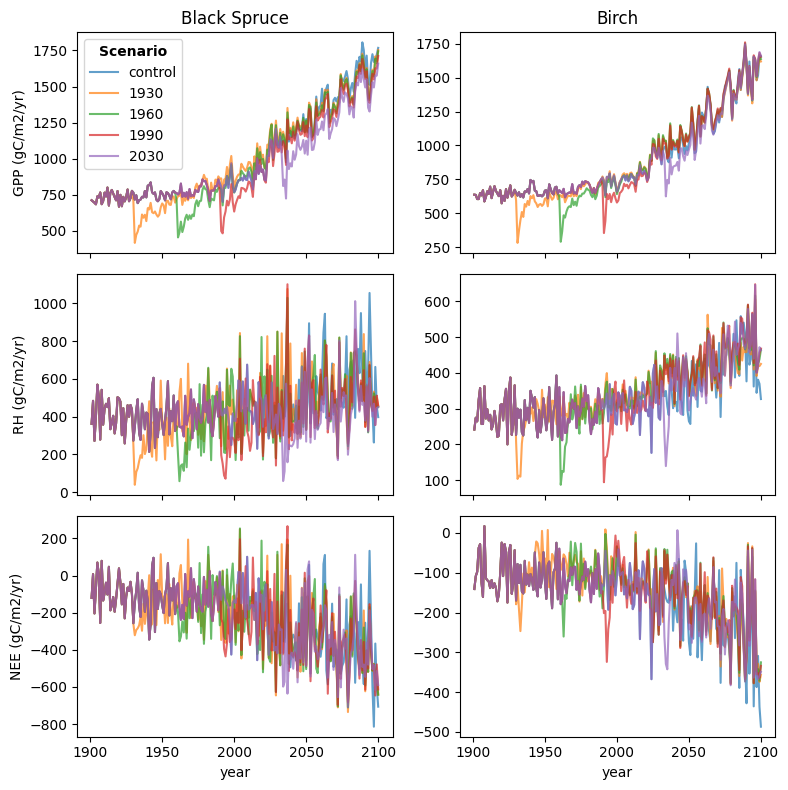

In [17]:
fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='GPP', hue='exp', ax=axes[0][0], alpha=0.7)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='RH', hue='exp', ax=axes[1][0], legend=False, alpha=0.7)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='NEE', hue='exp', ax=axes[2][0], legend=False, alpha=0.7)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('GPP (gC/m2/yr)')

new_labels = ['control', '1930', '1960', '1990', '2030']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('RH (gC/m2/yr)')
axes[2][0].set_ylabel('NEE (gC/m2/yr)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='GPP', hue='exp', ax=axes[0][1], legend=False, alpha=0.7)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='RH', hue='exp', ax=axes[1][1], legend=False, alpha=0.7)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='NEE', hue='exp', ax=axes[2][1], legend=False, alpha=0.7)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()

plt.savefig('C_Fluxes_fire_exps.jpg', dpi=300)

In [18]:
bin_interval=10
results_yearly['bin_lower_bound'] = np.floor(results_yearly['year']/bin_interval)
results_yearly['bin_lower_bound_year'] = results_yearly['bin_lower_bound']*bin_interval


/tmp/ipykernel_87/2543043442.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
/tmp/ipykernel_87/2543043442.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
/tmp/ipykernel_87/2543043442.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))


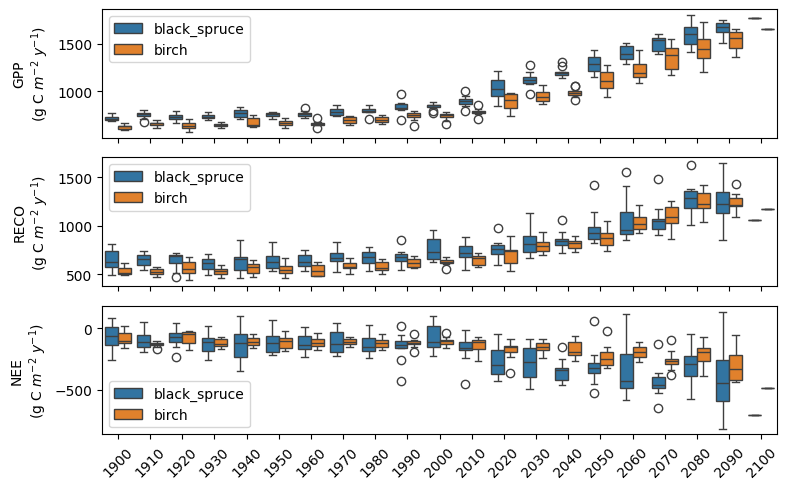

In [19]:
fig, axes=plt.subplots(3,1,figsize=(8,5), sharex=True)

#sns.set_palette(sns.color_palette(['#708891', '#E0DAD0']))
sns.boxplot(data=results_yearly.loc[results_yearly['exp']=='control'], x = 'bin_lower_bound', y = 'GPP', hue='cmt', ax=axes[0])
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[:], labels=labels[:])
axes[0].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
plt.xticks(rotation = 45)
axes[0].set_ylabel('GPP\n(g C $m^{-2}$ $y^{-1}$)')
axes[0].set_xlabel('')

sns.boxplot(data=results_yearly.loc[results_yearly['exp']=='control'], x = 'bin_lower_bound', y = 'RECO', hue='cmt', ax=axes[1])
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles[:], labels=labels[:])
axes[1].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
plt.xticks(rotation = 45)
axes[1].set_ylabel('RECO\n(g C $m^{-2}$ $y^{-1}$)')
axes[1].set_xlabel('')

sns.boxplot(data=results_yearly.loc[results_yearly['exp']=='control'], x = 'bin_lower_bound', y = 'NEE', hue='cmt', ax=axes[2])
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles=handles[:], labels=labels[:])
axes[2].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
plt.xticks(rotation = 45)
axes[2].set_ylabel('NEE\n(g C $m^{-2}$ $y^{-1}$)')
axes[2].set_xlabel('')

fig.tight_layout()
plt.savefig('control_flux_history.jpg', dpi=300)
plt.show()

/tmp/ipykernel_87/3166624632.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_87/3166624632.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_87/3166624632.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))


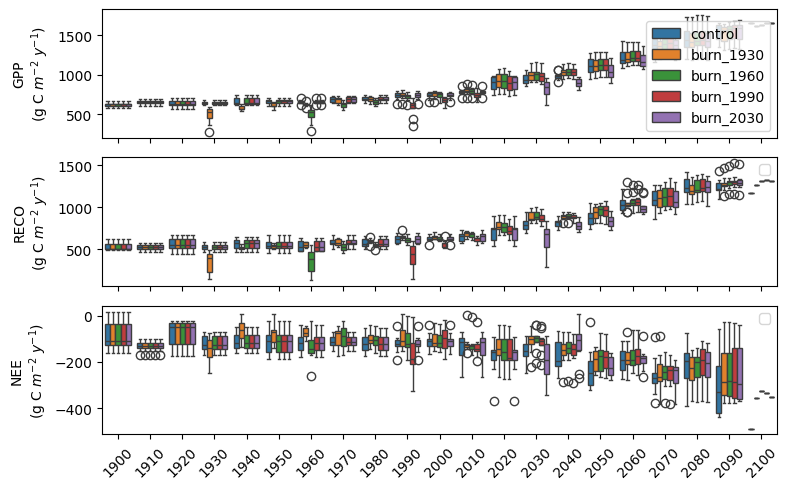

In [20]:
fig, axes=plt.subplots(3,1,figsize=(8,5), sharex=True)

#sns.set_palette(sns.color_palette(['#708891', '#E0DAD0']))
sns.boxplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x = 'bin_lower_bound', y = 'GPP', hue='exp', ax=axes[0])
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[:], labels=labels[:])
axes[0].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
plt.xticks(rotation = 45)
axes[0].set_ylabel('GPP\n(g C $m^{-2}$ $y^{-1}$)')
axes[0].set_xlabel('')

sns.boxplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
            x = 'bin_lower_bound', y = 'RECO', hue='exp', ax=axes[1], legend=False)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles[:], labels=labels[:])
axes[1].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
plt.xticks(rotation = 45)
axes[1].set_ylabel('RECO\n(g C $m^{-2}$ $y^{-1}$)')
axes[1].set_xlabel('')

sns.boxplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
            x = 'bin_lower_bound', y = 'NEE', hue='exp', ax=axes[2], legend=False)
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles=handles[:], labels=labels[:])
axes[2].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
plt.xticks(rotation = 45)
axes[2].set_ylabel('NEE\n(g C $m^{-2}$ $y^{-1}$)')
axes[2].set_xlabel('')

fig.tight_layout()

plt.show()

/tmp/ipykernel_87/2738201906.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
/tmp/ipykernel_87/2738201906.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
/tmp/ipykernel_87/2738201906.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))


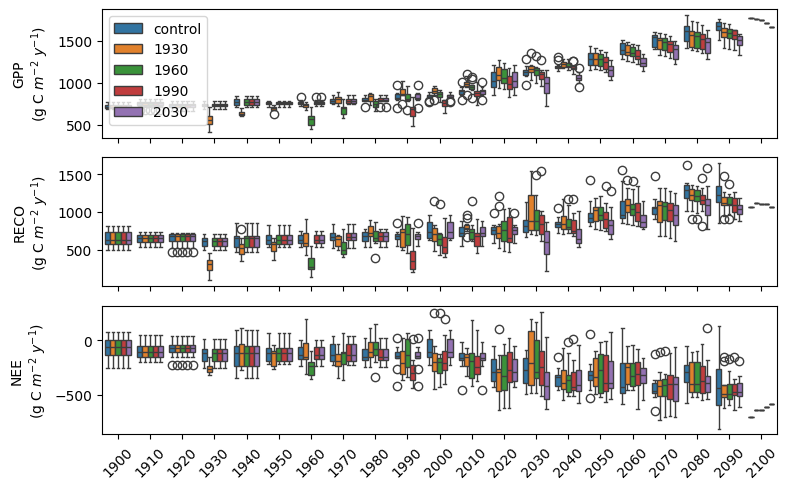

In [21]:
fig, axes=plt.subplots(3,1,figsize=(8,5), sharex=True)

#sns.set_palette(sns.color_palette(['#708891', '#E0DAD0']))
sns.boxplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x = 'bin_lower_bound', y = 'GPP', hue='exp', ax=axes[0])
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[:], labels=['control', '1930', '1960', '1990', '2030'], loc='upper left')
axes[0].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
plt.xticks(rotation = 45)
axes[0].set_ylabel('GPP\n(g C $m^{-2}$ $y^{-1}$)')
axes[0].set_xlabel('')

sns.boxplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
            x = 'bin_lower_bound', y = 'RECO', hue='exp', ax=axes[1], legend=False)
handles, labels = axes[1].get_legend_handles_labels()
#axes[1].legend(handles=handles[:], labels=labels[:])
axes[1].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
plt.xticks(rotation = 45)
axes[1].set_ylabel('RECO\n(g C $m^{-2}$ $y^{-1}$)')
axes[1].set_xlabel('')

sns.boxplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
            x = 'bin_lower_bound', y = 'NEE', hue='exp', ax=axes[2], legend=False)
handles, labels = axes[2].get_legend_handles_labels()
#axes[2].legend(handles=handles[:], labels=labels[:])
axes[2].set_xticklabels(results_yearly['bin_lower_bound_year'].unique().astype(int))
plt.xticks(rotation = 45)
axes[2].set_ylabel('NEE\n(g C $m^{-2}$ $y^{-1}$)')
axes[2].set_xlabel('')

fig.tight_layout()

plt.show()

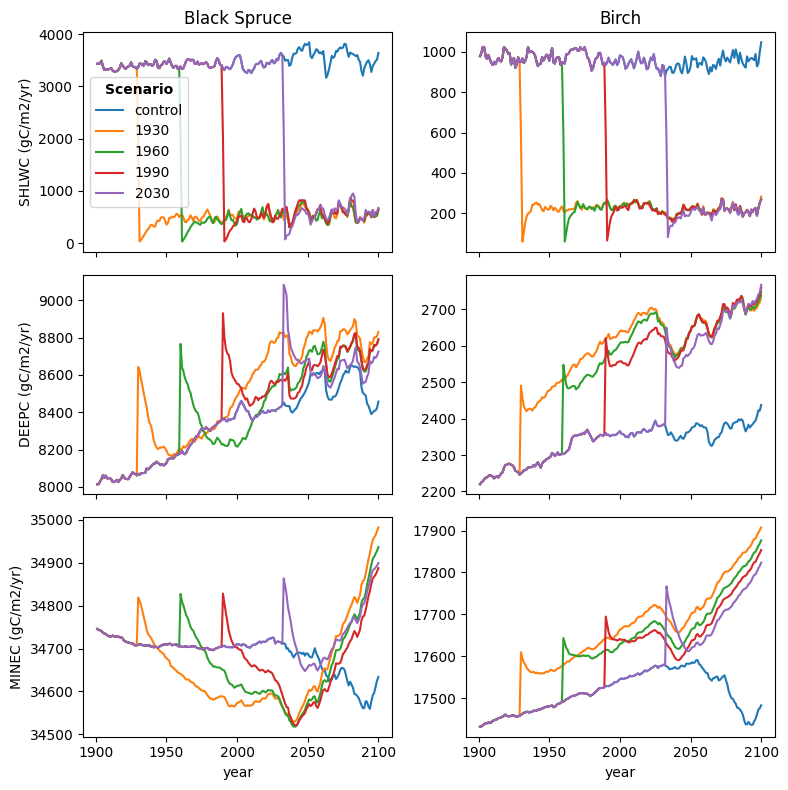

In [22]:
fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='SHLWC', hue='exp', ax=axes[0][0])
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='DEEPC', hue='exp', ax=axes[1][0], legend=False)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='MINEC', hue='exp', ax=axes[2][0], legend=False)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('SHLWC (gC/m2/yr)')

new_labels = ['control', '1930', '1960', '1990', '2030']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('DEEPC (gC/m2/yr)')
axes[2][0].set_ylabel('MINEC (gC/m2/yr)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='SHLWC', hue='exp', ax=axes[0][1], legend=False)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='DEEPC', hue='exp', ax=axes[1][1], legend=False)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='MINEC', hue='exp', ax=axes[2][1], legend=False)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('Soil_C_fire_exps.jpg', dpi=300)

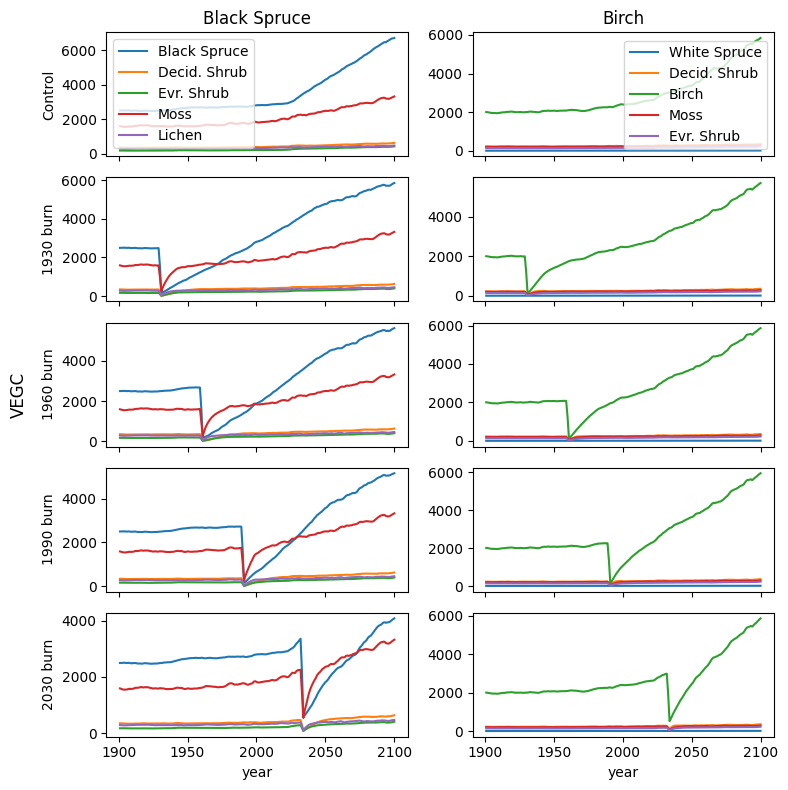

In [23]:
fig, axes = plt.subplots(5,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='black_spruce') & (results_yearly_pft['exp']=='control')], 
             x='year', y='VEGC', hue='pft', ax=axes[0][0])
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='black_spruce') & (results_yearly_pft['exp']=='burn_1930')], 
             x='year', y='VEGC', hue='pft', ax=axes[1][0], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='black_spruce') & (results_yearly_pft['exp']=='burn_1960')], 
             x='year', y='VEGC', hue='pft', ax=axes[2][0], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='black_spruce') & (results_yearly_pft['exp']=='burn_1990')], 
             x='year', y='VEGC', hue='pft', ax=axes[3][0], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='black_spruce') & (results_yearly_pft['exp']=='burn_2030')], 
             x='year', y='VEGC', hue='pft', ax=axes[4][0], legend=False)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('Control')
axes[0][0].legend(title=False)

    
axes[1][0].set_ylabel('1930 burn')
axes[2][0].set_ylabel('1960 burn')
axes[3][0].set_ylabel('1990 burn')
axes[4][0].set_ylabel('2030 burn')

sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='birch') & (results_yearly_pft['exp']=='control')], 
             x='year', y='VEGC', hue='pft', ax=axes[0][1])
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='birch') & (results_yearly_pft['exp']=='burn_1930')], 
             x='year', y='VEGC', hue='pft', ax=axes[1][1], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='birch') & (results_yearly_pft['exp']=='burn_1960')], 
             x='year', y='VEGC', hue='pft', ax=axes[2][1], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='birch') & (results_yearly_pft['exp']=='burn_1990')], 
             x='year', y='VEGC', hue='pft', ax=axes[3][1], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='birch') & (results_yearly_pft['exp']=='burn_2030')], 
             x='year', y='VEGC', hue='pft', ax=axes[4][1], legend=False)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')
axes[3][1].set_ylabel('')
axes[4][1].set_ylabel('')

axes[0][1].set_title('Birch')
axes[0][1].legend(title=False)

fig.supylabel('VEGC')
fig.tight_layout()

plt.savefig('VEGC_fire_exps.jpg', dpi=300)

In [24]:
results_yearly_part

""


In [25]:
if len(results_yearly_part>0):
    fig, axes = plt.subplots(4,2, figsize=(8,8), sharex=True)


    sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='black_spruce') & 
                                              (results_yearly_part['exp']=='control') &
                                              (results_yearly_part['pft']==0)], 
                 x='year', y='VEGC', hue='pftpart', ax=axes[0][0])
    sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='black_spruce') & (results_yearly_part['exp']=='burn_1930')&
                                              (results_yearly_part['pft']==0)], 
                 x='year', y='VEGC', hue='pftpart', ax=axes[1][0], legend=False)
    sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='black_spruce') & (results_yearly_part['exp']=='burn_1960')&
                                              (results_yearly_part['pft']==0)], 
                 x='year', y='VEGC', hue='pftpart', ax=axes[2][0], legend=False)
    sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='black_spruce') & (results_yearly_part['exp']=='burn_1990')&
                                              (results_yearly_part['pft']==0)], 
                 x='year', y='VEGC', hue='pftpart', ax=axes[3][0], legend=False)

    axes[0][0].set_title('Black Spruce')
    axes[0][0].set_ylabel('Control')


    axes[1][0].set_ylabel('1930 burn')

    #axes[1][0].set_ylim(0,200)

    axes[2][0].set_ylabel('1960 burn')
    axes[3][0].set_ylabel('1990 burn')

    sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='birch') & (results_yearly_part['exp']=='control')&
                                              (results_yearly_part['pft']==2)], 
                 x='year', y='VEGC', hue='pftpart', ax=axes[0][1])
    sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='birch') & (results_yearly_part['exp']=='burn_1930')&
                                              (results_yearly_part['pft']==2)], 
                 x='year', y='VEGC', hue='pftpart', ax=axes[1][1], legend=False)
    sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='birch') & (results_yearly_part['exp']=='burn_1960')&
                                              (results_yearly_part['pft']==2)], 
                 x='year', y='VEGC', hue='pftpart', ax=axes[2][1], legend=False)
    sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='birch') & (results_yearly_part['exp']=='burn_1990')&
                                              (results_yearly_part['pft']==2)], 
                 x='year', y='VEGC', hue='pftpart', ax=axes[3][1], legend=False)

    axes[0][1].set_ylabel('')
    axes[1][1].set_ylabel('')
    axes[2][1].set_ylabel('')

    axes[0][1].set_title('Birch')

    fig.supylabel('VEGC')
    fig.tight_layout()

    plt.savefig('VEGC_tree_fire_exps.jpg', dpi=300)

In [26]:
if len(results_yearly_part>0):
    results_yearly_part.loc[(results_yearly_part['cmt']=='black_spruce') & (results_yearly_part['exp']=='burn_1930')&
                                              (results_yearly_part['pft']==0)
                                               & (results_yearly_part['pftpart']==0)]

In [27]:
pal=sns.color_palette(['#5d5e5e', '#faae34', '#ba6714', '#752f00'])

In [28]:
t_layers

,time,year,x,y,layer,z,type,TLAYER,TLAYER_top,TLAYER_bot,exp,cmt
0,1901-01-01,1901,0,0,0,0.08,1.0,-1.352016,-0.911678,-1.910969,control,black_spruce
1,1902-01-01,1902,0,0,0,0.08,1.0,-1.352565,-0.888438,-1.956045,control,black_spruce
2,1903-01-01,1903,0,0,0,0.08,1.0,-2.951655,-2.502253,-3.517867,control,black_spruce
3,1904-01-01,1904,0,0,0,0.08,1.0,-4.142891,-3.714614,-4.714634,control,black_spruce
4,1905-01-01,1905,0,0,0,0.08,1.0,-1.877463,-1.418036,-2.488993,control,black_spruce
...,...,...,...,...,...,...,...,...,...,...,...,...
201,2095-01-03,2095,0,0,3,0.30,3.0,8.171495,8.310097,8.156451,burn_2030,birch
202,2096-01-03,2096,0,0,3,0.30,3.0,6.502366,6.589786,6.496820,burn_2030,birch
203,2097-01-03,2097,0,0,3,0.30,3.0,6.020533,6.180482,6.005945,burn_2030,birch
204,2098-01-03,2098,0,0,3,0.30,3.0,6.513548,6.615679,6.502555,burn_2030,birch


/tmp/ipykernel_87/244621536.py:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/244621536.py:8: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='black_spruce') & (t_layers['z']==0.2)],
/tmp/ipykernel_87/244621536.py:10: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='black_spruce') & (t_layers['z']==0.3)],
/tmp/ipykernel_87/244621536.py:25: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'],
/tmp/ipykernel_87/2

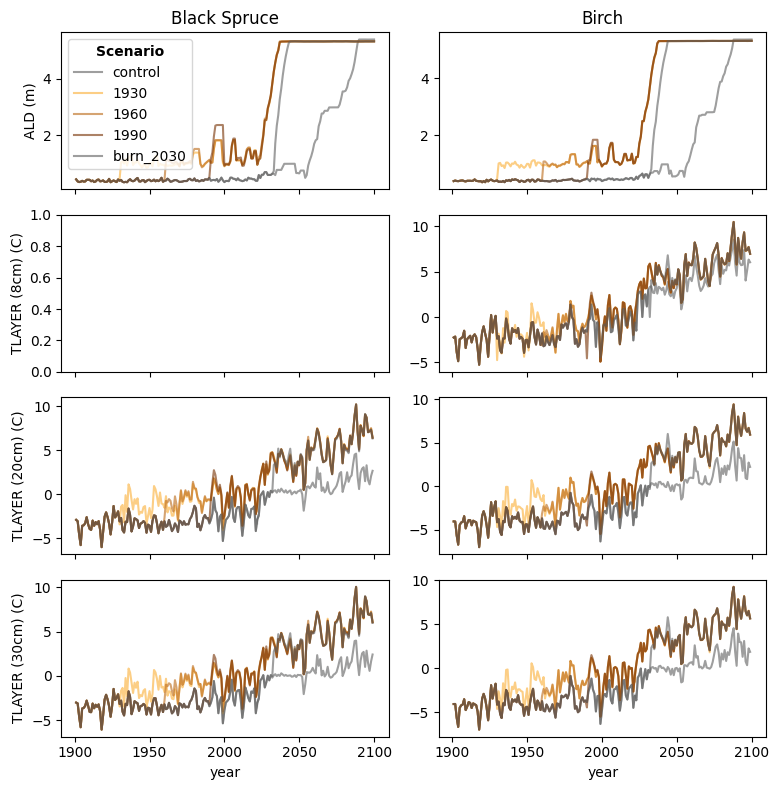

In [29]:
fig, axes = plt.subplots(4,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='ALD', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
#sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='black_spruce') & (t_layers['z']==0.08)], 
#             x='year', y='TLAYER', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='black_spruce') & (t_layers['z']==0.2)], 
             x='year', y='TLAYER', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='black_spruce') & (t_layers['z']==0.3)], 
             x='year', y='TLAYER', hue='exp', ax=axes[3][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('ALD (m)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('TLAYER (8cm) (C)')
axes[2][0].set_ylabel('TLAYER (20cm) (C)')
axes[3][0].set_ylabel('TLAYER (30cm) (C)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='ALD', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='birch') & (t_layers['z']==0.08)], 
             x='year', y='TLAYER', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='birch') & (t_layers['z']==0.2)], 
             x='year', y='TLAYER', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='birch') & (t_layers['z']==0.3)], 
             x='year', y='TLAYER', hue='exp', ax=axes[3][1], legend=False, palette=pal, alpha=0.6)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')
axes[3][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('ALD_tlayer_fire_exps.jpg', dpi=300)

/tmp/ipykernel_87/2457401149.py:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/2457401149.py:6: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='black_spruce') & (lwc_layers['z']==0.08)],
/tmp/ipykernel_87/2457401149.py:8: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='black_spruce') & (lwc_layers['z']==0.2)],
/tmp/ipykernel_87/2457401149.py:10: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='black_spruce') & (l

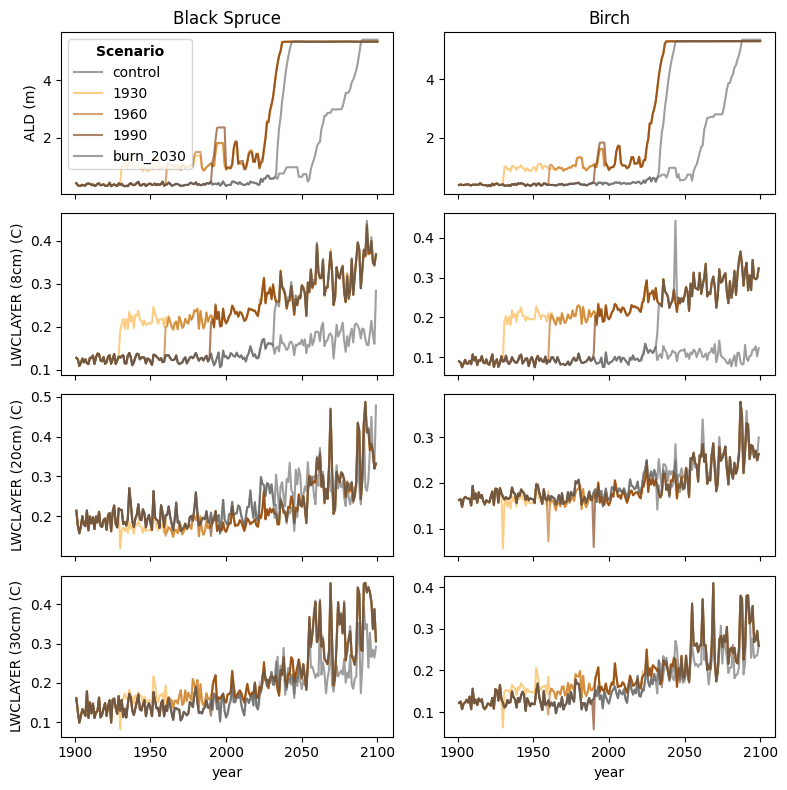

In [30]:
fig, axes = plt.subplots(4,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='ALD', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='black_spruce') & (lwc_layers['z']==0.08)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='black_spruce') & (lwc_layers['z']==0.2)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='black_spruce') & (lwc_layers['z']==0.3)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[3][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('ALD (m)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('LWCLAYER (8cm) (C)')
axes[2][0].set_ylabel('LWCLAYER (20cm) (C)')
axes[3][0].set_ylabel('LWCLAYER (30cm) (C)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='ALD', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='birch') & (lwc_layers['z']==0.08)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='birch') & (lwc_layers['z']==0.2)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='birch') & (lwc_layers['z']==0.3)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[3][1], legend=False, palette=pal, alpha=0.6)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')
axes[3][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('ALD_lwclayer_fire_exps.jpg', dpi=300)

/tmp/ipykernel_87/471373374.py:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/471373374.py:6: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/471373374.py:8: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/471373374.py:10: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/471373374.py:25: User

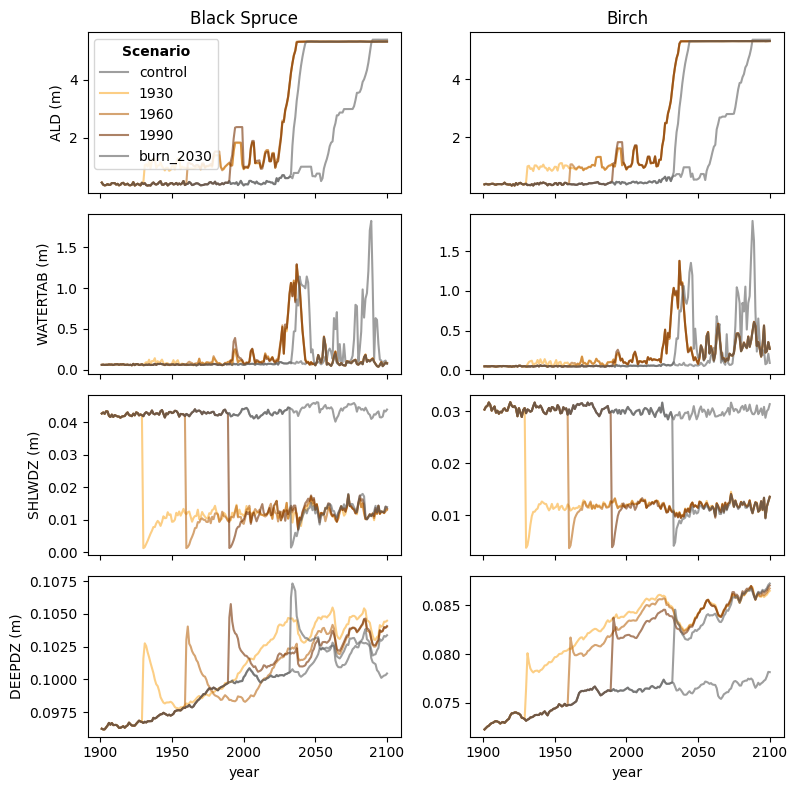

In [31]:
fig, axes = plt.subplots(4,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='ALD', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='WATERTAB', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SHLWDZ', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='DEEPDZ', hue='exp', ax=axes[3][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('ALD (m)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('WATERTAB (m)')
axes[2][0].set_ylabel('SHLWDZ (m)')
axes[3][0].set_ylabel('DEEPDZ (m)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='ALD', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='WATERTAB', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SHLWDZ', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='DEEPDZ', hue='exp', ax=axes[3][1], legend=False, palette=pal, alpha=0.6)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')
axes[3][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('WATERTAB_DZ_fire_exps.jpg', dpi=300)

/tmp/ipykernel_87/4192164695.py:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/4192164695.py:6: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/4192164695.py:8: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/4192164695.py:23: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'],
/tmp/ipykernel_87/4192164695.py:25: UserWa

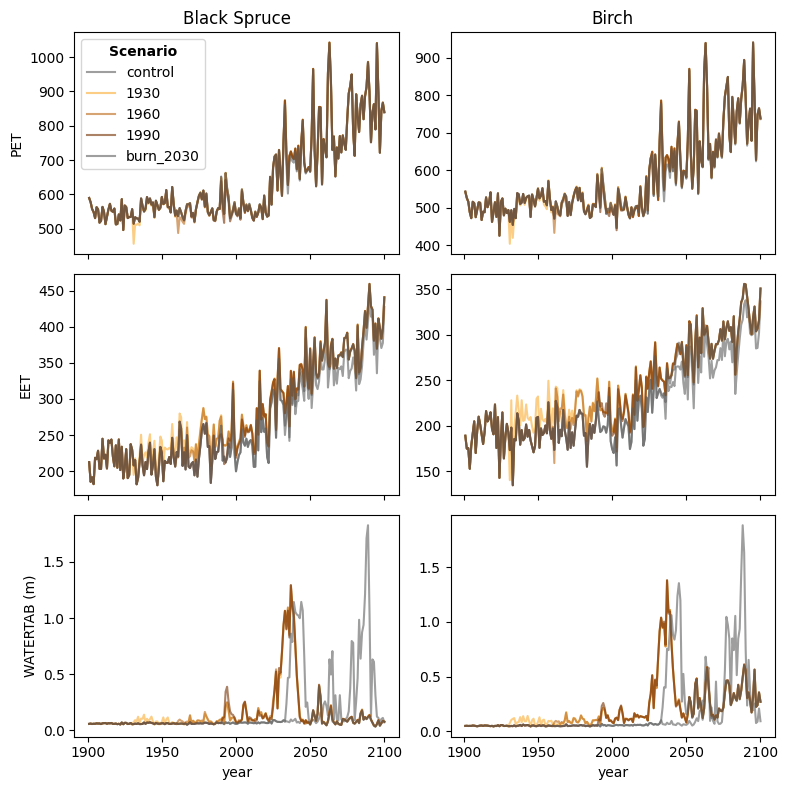

In [32]:
fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='PET', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='EET', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='WATERTAB', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('PET')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('EET')
axes[2][0].set_ylabel('WATERTAB (m)')


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='PET', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='EET', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='WATERTAB', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)


axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('ET_fire_exps.jpg', dpi=300)

/tmp/ipykernel_87/1316770546.py:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/1316770546.py:6: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/1316770546.py:8: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/1316770546.py:10: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/1316770546.py:12:

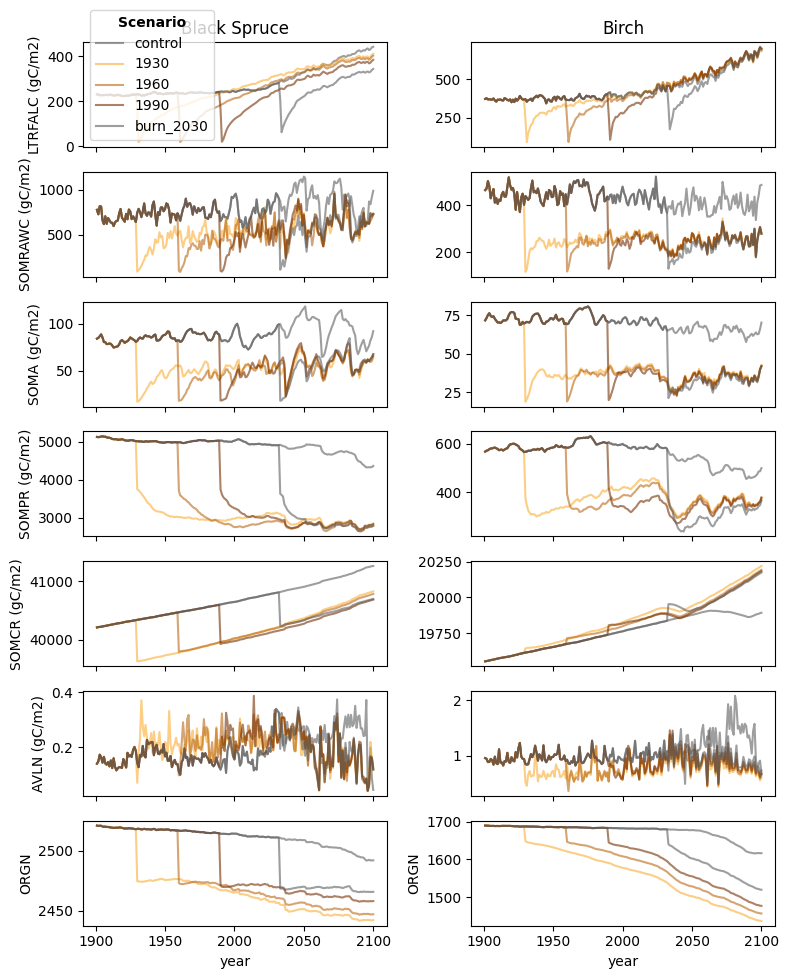

In [33]:
fig, axes = plt.subplots(7,2, figsize=(8,10), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='LTRFALC', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SOMRAWC', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SOMA', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SOMPR', hue='exp', ax=axes[3][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SOMCR', hue='exp', ax=axes[4][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='AVLN', hue='exp', ax=axes[5][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='ORGN', hue='exp', ax=axes[6][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('LTRFALC (gC/m2)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('SOMRAWC (gC/m2)')
axes[2][0].set_ylabel('SOMA (gC/m2)')
axes[3][0].set_ylabel('SOMPR (gC/m2)')
axes[4][0].set_ylabel('SOMCR (gC/m2)')
axes[5][0].set_ylabel('AVLN (gC/m2)')

#axes[5][0].set_ylim(1.64,1.645)

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='LTRFALC', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SOMRAWC', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SOMA', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SOMPR', hue='exp', ax=axes[3][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SOMCR', hue='exp', ax=axes[4][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='AVLN', hue='exp', ax=axes[5][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='ORGN', hue='exp', ax=axes[6][1], legend=False, palette=pal, alpha=0.6)

#axes[6,0].set_ylim(2100,2300)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')
axes[3][1].set_ylabel('')
axes[4][1].set_ylabel('')
axes[5][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('Pools_fire_exps.jpg', dpi=300)

/tmp/ipykernel_87/575820681.py:2: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/575820681.py:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],


(2035.0, 2040.0)

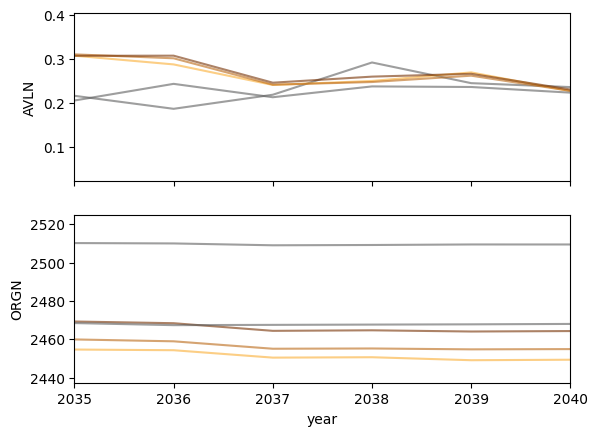

In [34]:
fig, axes=plt.subplots(2,1, sharex=True)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='AVLN', hue='exp', ax=axes[0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='ORGN', hue='exp', ax=axes[1], legend=False, palette=pal, alpha=0.6)
plt.xlim(2035, 2040)

In [35]:
results_yearly.loc[(results_yearly['cmt']=='black_spruce') & (results_yearly['exp']=='control')][['year', 'AVLN']]

,year,AVLN
0,1901,0.140216
1,1902,0.148761
2,1903,0.172956
3,1904,0.163621
4,1905,0.143864
...,...,...
195,2096,0.071481
196,2097,0.120778
197,2098,0.198295
198,2099,0.088008


In [36]:
results_yearly.loc[(results_yearly['cmt']=='black_spruce') & (results_yearly['exp']=='control')][['year', 'ORGN']]

,year,ORGN
0,1901,2521.055015
1,1902,2520.766514
2,1903,2520.942704
3,1904,2520.882599
4,1905,2520.330955
...,...,...
195,2096,2492.069628
196,2097,2492.443639
197,2098,2491.966951
198,2099,2492.041115


/tmp/ipykernel_87/1280742133.py:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/1280742133.py:6: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/1280742133.py:8: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'],
/tmp/ipykernel_87/1280742133.py:23: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'],
/tmp/ipykernel_87/1280742133.py:25: UserWa

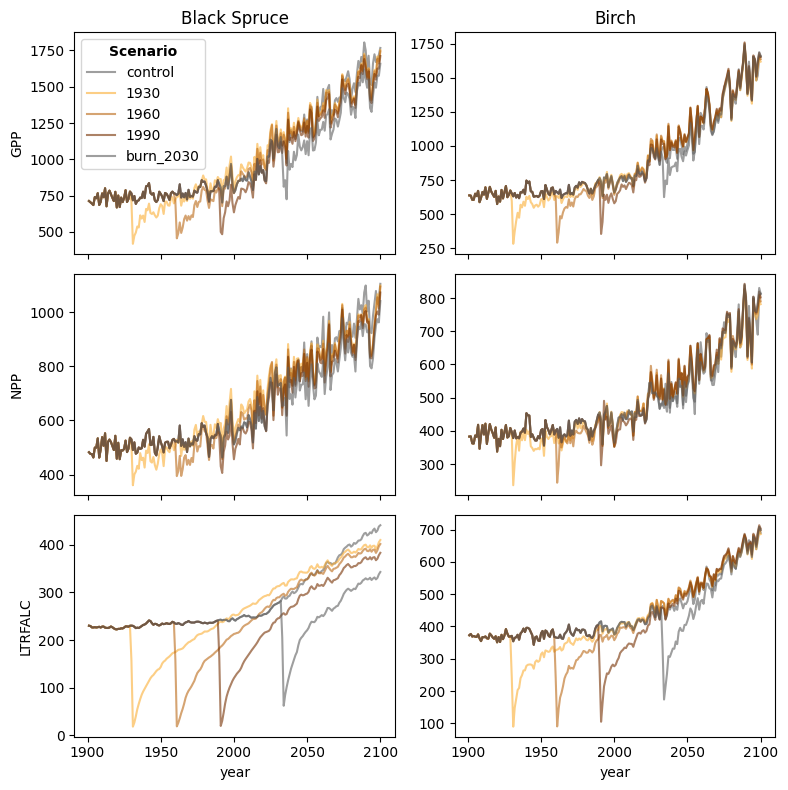

In [37]:
fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='GPP', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='NPP', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='LTRFALC', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('GPP')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('NPP')
axes[2][0].set_ylabel('LTRFALC')


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='GPP', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='NPP', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='LTRFALC', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)


axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('ET_fire_exps.jpg', dpi=300)

In [38]:
vegc_yearly = results_yearly_pft.groupby(by=['burn_year', 'cmt', 'exp', 'year']).sum().reset_index()
vegc_yearly['VEGC_diff'] = vegc_yearly['VEGC'].diff()
vegc_yearly = vegc_yearly.merge(results_yearly[['burn_year', 'cmt', 'exp', 'year', 'NPP', 'LTRFALC']], on = ['burn_year', 'cmt', 'exp', 'year'])
vegc_yearly['balance'] = vegc_yearly['VEGC_diff'] - (vegc_yearly['NPP'] - vegc_yearly['LTRFALC'])
vegc_yearly

,burn_year,cmt,exp,year,VEGC,VEGC_diff,NPP,LTRFALC,balance
0,1900,birch,control,1901,2589.015864,NaN,382.681413,372.716764,NaN
1,1900,birch,control,1902,2576.298792,-12.717072,383.254705,376.672510,-19.299267
2,1900,birch,control,1903,2557.054334,-19.244458,362.295375,368.746113,-12.793720
3,1900,birch,control,1904,2535.192727,-21.861606,361.658557,370.338688,-13.181476
4,1900,birch,control,1905,2523.997309,-11.195418,385.738961,368.326826,-28.607553
...,...,...,...,...,...,...,...,...,...
1995,2030,black_spruce,burn_2030,2096,8539.586929,1.080462,903.532742,331.498731,-570.953548
1996,2030,black_spruce,burn_2030,2097,8608.826302,69.239373,950.687832,327.357429,-554.091030
1997,2030,black_spruce,burn_2030,2098,8723.433987,114.607685,973.467718,330.491423,-528.368610
1998,2030,black_spruce,burn_2030,2099,8824.956644,101.522657,961.558168,338.052572,-521.982940


<AxesSubplot:xlabel='year', ylabel='balance'>

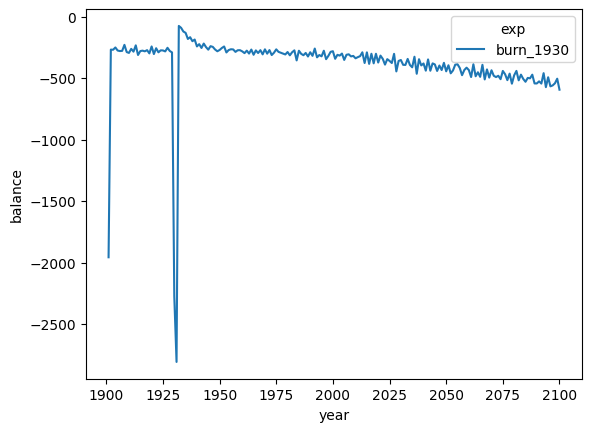

In [39]:
sns.lineplot(data = vegc_yearly.loc[(vegc_yearly['cmt']=='black_spruce') & (vegc_yearly['exp']=='burn_1930')], x='year', y = 'balance', hue = 'exp')

/tmp/ipykernel_87/815832383.py:1: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'],


<AxesSubplot:xlabel='year', ylabel='None'>

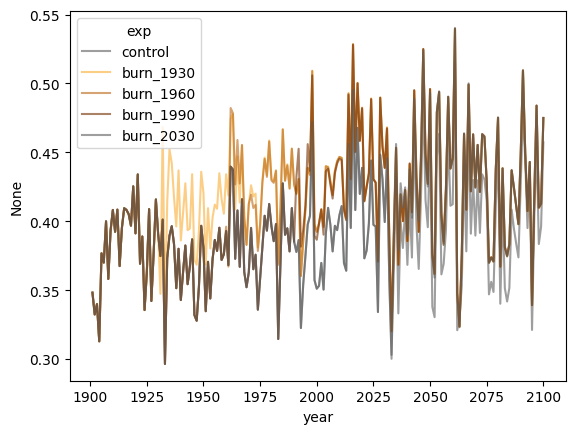

In [40]:
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y=results_yearly.loc[results_yearly['cmt']=='birch','EET']/results_yearly.loc[results_yearly['cmt']=='birch','PET'], 
             hue='exp', palette=pal, alpha=0.6)

In [41]:
emissions = results_yearly[['year', 'exp', 'cmt', 'burn_year', 'BURNSOIC', 'BURNVEG2AIRC']].groupby(by=['exp', 'cmt', 'burn_year']).sum().reset_index()
emissions['total'] = emissions['BURNSOIC'] + emissions['BURNVEG2AIRC']

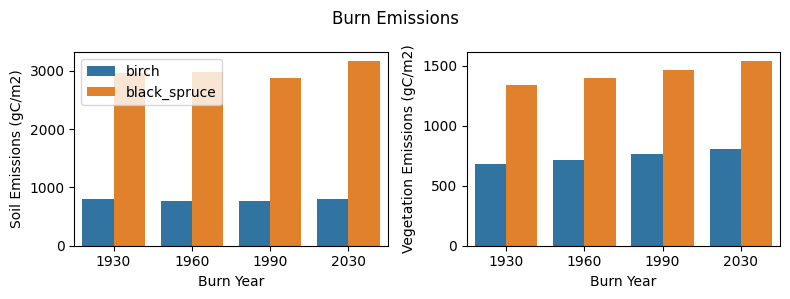

In [42]:
fig, axes=plt.subplots(1,2, figsize=(8,3), sharex=True)
sns.barplot(data=emissions.loc[emissions['exp']!='control'], x='burn_year', y='BURNSOIC', hue='cmt', ax=axes[0])
sns.barplot(data=emissions.loc[emissions['exp']!='control'], x='burn_year', y='BURNVEG2AIRC', hue='cmt', ax=axes[1], legend=False)

axes[0].set_xlabel('Burn Year')
axes[1].set_xlabel('Burn Year')
axes[0].set_ylabel('Soil Emissions (gC/m2)')
axes[1].set_ylabel('Vegetation Emissions (gC/m2)')

axes[0].legend(title=False, loc='upper left')
plt.suptitle('Burn Emissions')
fig.tight_layout()
plt.savefig('burn_emissions.jpg', dpi=300)

In [43]:
results_yearly['growing_days'] = results_yearly['GROWEND'] - results_yearly['GROWSTART']

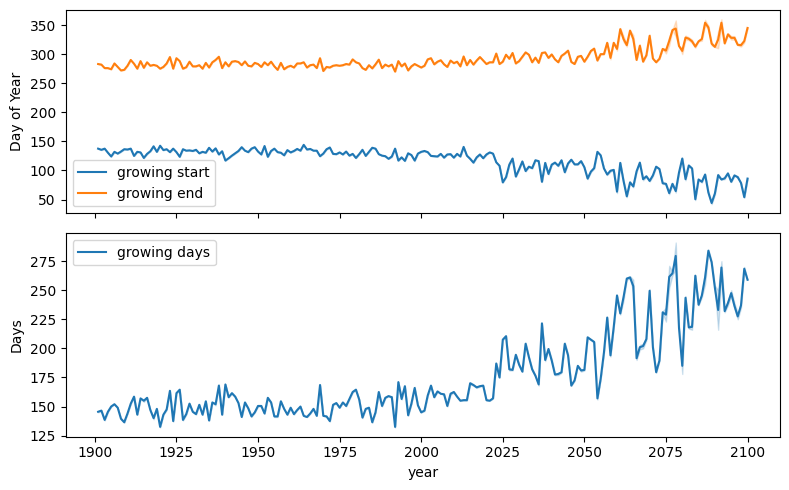

In [44]:
fig, axes=plt.subplots(2, 1, figsize=(8,5), sharex=True)

sns.lineplot(data=results_yearly.loc[results_yearly['exp']=='control'], x='year', y='GROWSTART', 
             label='growing start', ax=axes[0])

sns.lineplot(data=results_yearly.loc[results_yearly['exp']=='control'], x='year', y='GROWEND', 
             label='growing end', ax=axes[0])
axes[0].set_ylabel('Day of Year')
axes[0].set_xlabel('')

sns.lineplot(data=results_yearly.loc[results_yearly['exp']=='control'], x='year', y='growing_days', 
             label='growing days', ax=axes[1])

axes[1].set_ylabel('Days')

fig.tight_layout()
plt.savefig('growing_days.jpg', dpi=300)

In [45]:
carbon_summary = results_yearly_pft.groupby(by=['year', 'cmt', 'exp', 'burn_year']).sum().reset_index()

In [46]:
results_yearly=results_yearly.merge(carbon_summary, on=['year', 'cmt', 'exp', 'burn_year'])

In [47]:
results_yearly.columns

Index(['index', 'year', 'GPP', 'exp', 'cmt', 'burn_year', 'NPP', 'RH', 'RG',
       'RM', 'LTRFALC', 'SHLWC', 'time_x', 'DEEPC', 'time_y', 'MINEC',
       'time_x', 'AVLN', 'time_y', 'ORGN', 'time_x', 'ALD', 'time_y', 'SHLWDZ',
       'time_x', 'DEEPDZ', 'time_y', 'WATERTAB', 'time_x', 'EET', 'time_y',
       'PET', 'time_x', 'SOMA', 'time_y', 'SOMCR', 'time_x', 'SOMPR', 'time_y',
       'SOMRAWC', 'time_x', 'BURNVEG2AIRC', 'time_y', 'BURNSOIC', 'time_x',
       'GROWSTART', 'time_y', 'GROWEND', 'time', 'YSD', 'RECO', 'NEE',
       'years_since_fire', 'bin_lower_bound', 'bin_lower_bound_year',
       'growing_days', 'VEGC'],
      dtype='object')

In [48]:
results_yearly['years_since_fire']

0        1
1        2
2        3
3        4
4        5
        ..
1995    66
1996    67
1997    68
1998    69
1999    70
Name: years_since_fire, Length: 2000, dtype: int64

In [95]:
year_before_fire = []

pre_fire = results_yearly.loc[(results_yearly['years_since_fire'] == 0)].groupby(by=['exp', 'cmt', 'burn_year'])

for name, group in pre_fire:
    year_before_fire.append(group.loc[group['index']==group['year'].idxmax()])
    
year_before_fire = pd.concat(year_before_fire)

In [96]:
year_before_fire

,index,year,GPP,exp,cmt,burn_year,NPP,RH,RG,RM,...,GROWEND,time,YSD,RECO,NEE,years_since_fire,bin_lower_bound,bin_lower_bound_year,growing_days,VEGC
1229,1229,1930,596.388813,burn_1930,birch,1930,387.514168,208.238927,44.482405,164.392240,...,280,1930-01-01,1,417.113572,-179.275241,0,193.0,1930.0,147,1551.767699
229,229,1930,709.543794,burn_1930,black_spruce,1930,511.536832,251.258381,57.644216,140.362756,...,280,1930-01-01,1,449.265352,-260.278441,0,193.0,1930.0,146,2952.415860
1459,1459,1960,622.697673,burn_1960,birch,1960,401.839666,333.741629,46.694514,174.163490,...,280,1960-01-01,1,554.599632,-68.098041,0,196.0,1960.0,149,1609.345144
459,459,1960,712.440908,burn_1960,black_spruce,1960,509.516782,349.752899,57.793727,145.130410,...,280,1960-01-01,1,552.677036,-159.763872,0,196.0,1960.0,149,3092.810698
1689,1689,1990,703.916078,burn_1990,birch,1990,442.218615,296.211776,51.168065,210.529385,...,280,1990-01-01,1,557.909225,-146.006853,0,199.0,1990.0,160,1741.611571
689,689,1990,772.279291,burn_1990,black_spruce,1990,537.911526,551.847173,60.972580,173.395194,...,280,1990-01-01,1,786.214947,13.935656,0,199.0,1990.0,160,3254.466434
1929,1929,2030,923.859928,burn_2030,birch,2030,499.146029,269.261685,62.974839,361.739066,...,288,2030-01-01,830,693.975590,-229.884338,0,203.0,2030.0,187,3650.288260
929,929,2030,1091.882529,burn_2030,black_spruce,2030,726.845709,307.838476,85.447925,279.588897,...,288,2030-01-01,830,672.875298,-419.007231,0,203.0,2030.0,185,6590.758449


In [97]:
ysd = results_yearly.loc[(results_yearly['years_since_fire'] != 0)]
ysd = results_yearly.loc[(results_yearly['YSD'] < 500)]

ysd = ysd.merge(year_before_fire, on = ['exp', 'cmt', 'burn_year'], suffixes=['', '_prefire'])

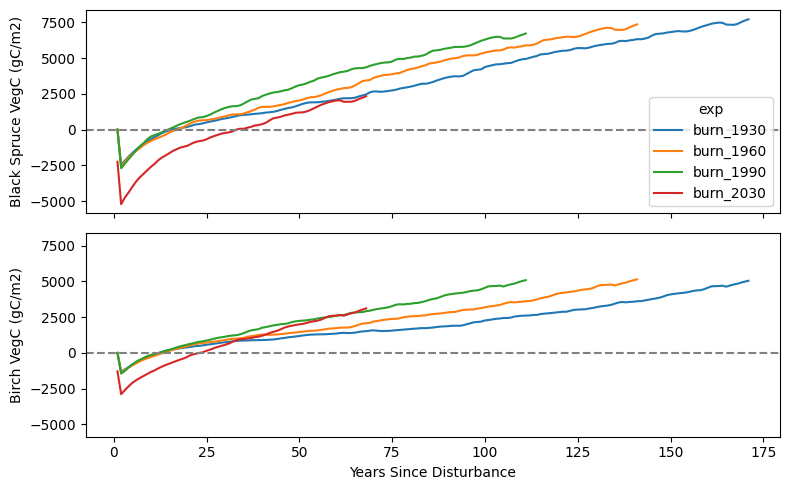

In [98]:
fig, axes=plt.subplots(2, 1, figsize = (8,5), sharey=True, sharex=True)

sns.lineplot(data=ysd.loc[ysd['cmt'] == 'black_spruce'], x='YSD', 
             y=ysd['VEGC'] - ysd['VEGC_prefire'], hue='exp', ax=axes[0])

sns.lineplot(data=ysd.loc[ysd['cmt'] == 'birch'], x='YSD', 
             y=ysd['VEGC'] - ysd['VEGC_prefire'], hue='exp', ax=axes[1], legend=False)

axes[0].axhline(y = 0, color = 'grey', linestyle = '--')
axes[1].axhline(y = 0, color = 'grey', linestyle = '--') 

axes[0].set_ylabel('Black Spruce VegC (gC/m2)')
axes[1].set_ylabel('Birch VegC (gC/m2)')
axes[1].set_xlabel('Years Since Disturbance')
fig.tight_layout()
plt.savefig('VegC_recovery.jpg', dpi=300)

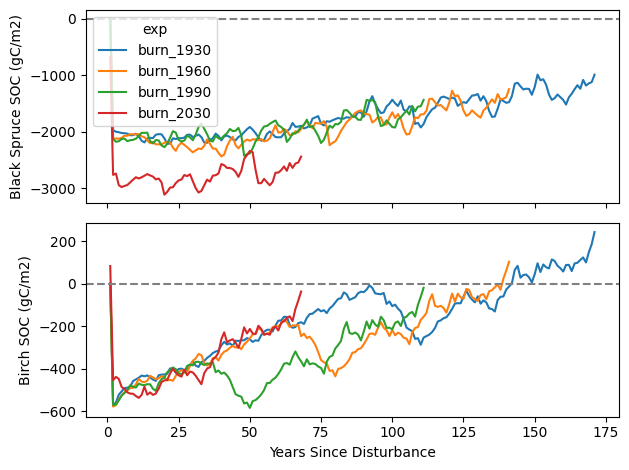

In [99]:
fig, axes=plt.subplots(2,1, sharex=True)

sns.lineplot(data=ysd.loc[ysd['cmt']=='black_spruce'], x='YSD', y=(ysd['DEEPC']+ysd['SHLWC']+ysd['MINEC']) - (ysd['DEEPC_prefire']+ysd['SHLWC_prefire']+ysd['MINEC_prefire']), 
             hue='exp', ax=axes[0])
sns.lineplot(data=ysd.loc[ysd['cmt']=='birch'], x='YSD', y=(ysd['DEEPC']+ysd['SHLWC']+ysd['MINEC']) - (ysd['DEEPC_prefire']+ysd['SHLWC_prefire']+ysd['MINEC_prefire']), 
             hue='exp', ax=axes[1], legend=False)

axes[0].axhline(y = 0, color = 'grey', linestyle = '--')
axes[1].axhline(y = 0, color = 'grey', linestyle = '--')

axes[0].set_ylabel('Black Spruce SOC (gC/m2)')
axes[1].set_ylabel('Birch SOC (gC/m2)')
axes[1].set_xlabel('Years Since Disturbance')
fig.tight_layout()

plt.savefig('SoilC_recovery.jpg', dpi=300)

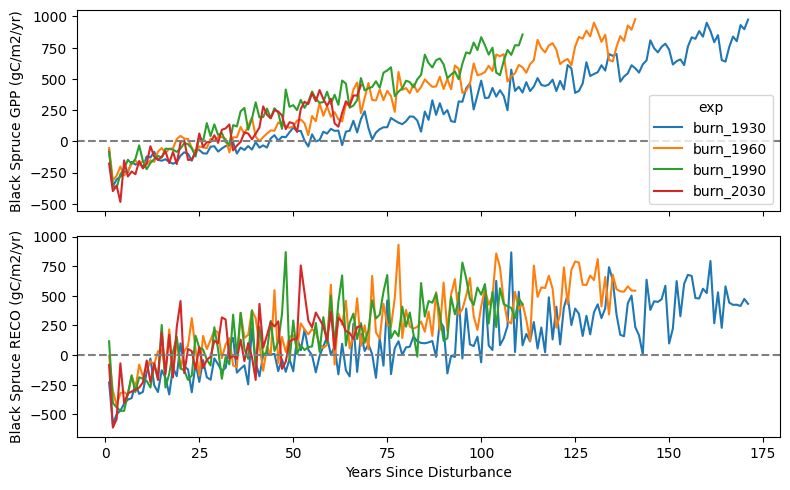

In [66]:
fig, axes=plt.subplots(2,1, figsize=(8,5), sharex=True)
sns.lineplot(data=ysd.loc[ysd['cmt']=='black_spruce'], x='YSD', y=ysd['GPP'] - ysd['GPP_prefire'], hue='exp', ax=axes[0])
sns.lineplot(data=ysd.loc[ysd['cmt']=='black_spruce'], x='YSD', y=ysd['RECO'] - ysd['RECO_prefire'], hue='exp', ax=axes[1], legend=False)

axes[0].axhline(y = 0, color = 'grey', linestyle = '--')
axes[1].axhline(y = 0, color = 'grey', linestyle = '--')

axes[0].set_ylabel('Black Spruce GPP (gC/m2/yr)')
axes[1].set_ylabel('Black Spruce RECO (gC/m2/yr)')
axes[0].set_xlabel('Years Since Disturbance')
axes[1].set_xlabel('Years Since Disturbance')

fig.tight_layout()
plt.savefig('Black_Spruce_Flux_recovery.jpg', dpi=300)

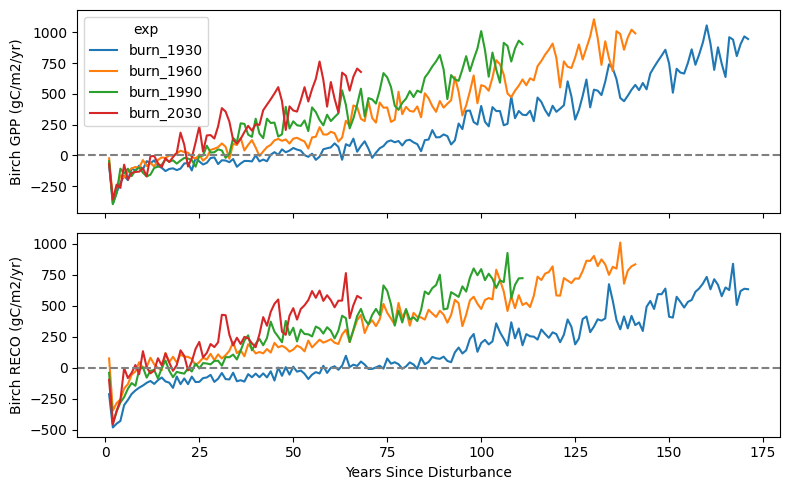

In [67]:
fig, axes=plt.subplots(2,1, figsize=(8,5), sharex=True)
sns.lineplot(data=ysd.loc[ysd['cmt']=='birch'], x='YSD', y=ysd['GPP'] - ysd['GPP_prefire'], hue='exp', ax=axes[0])
sns.lineplot(data=ysd.loc[ysd['cmt']=='birch'], x='YSD', y=ysd['RECO'] - ysd['RECO_prefire'], hue='exp', ax=axes[1], legend=False)

axes[0].axhline(y = 0, color = 'grey', linestyle = '--')
axes[1].axhline(y = 0, color = 'grey', linestyle = '--')

axes[0].set_ylabel('Birch GPP (gC/m2/yr)')
axes[1].set_ylabel('Birch RECO (gC/m2/yr)')
axes[0].set_xlabel('Years Since Disturbance')
axes[1].set_xlabel('Years Since Disturbance')

fig.tight_layout()
plt.savefig('Birch_Flux_recovery.jpg', dpi=300)

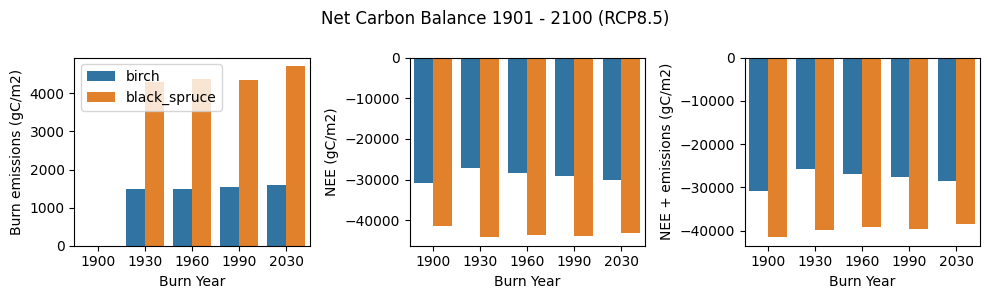

In [68]:
emissions = results_yearly[['year', 'exp', 'cmt', 'burn_year', 'BURNSOIC', 'BURNVEG2AIRC']].groupby(by=['exp', 'cmt', 'burn_year']).sum().reset_index()
emissions['total'] = emissions['BURNSOIC'] + emissions['BURNVEG2AIRC']

flux_sum = results_yearly[['year', 'exp', 'cmt', 'burn_year', 'NEE']].groupby(by=['exp', 'cmt', 'burn_year']).sum().reset_index()
flux_sum['burn_year'] = flux_sum['burn_year'].astype(int)

fig, axes=plt.subplots(1,3,figsize=(10,3))

sns.barplot(data=emissions, x='burn_year', 
            y='total', hue='cmt', ax=axes[0])

sns.barplot(data=flux_sum, x='burn_year', 
            y='NEE', hue='cmt', ax=axes[1], legend=False)

sns.barplot(data=flux_sum, x='burn_year', 
            y=flux_sum['NEE'] + emissions['total'], 
            hue='cmt', ax=axes[2], legend=False)

axes[0].set_xlabel('Burn Year')
axes[0].set_ylabel('Burn emissions (gC/m2)')
axes[1].set_xlabel('Burn Year')
axes[1].set_ylabel('NEE (gC/m2)')
axes[2].set_xlabel('Burn Year')
axes[2].set_ylabel('NEE + emissions (gC/m2)')

axes[0].legend(title=False, loc='upper left')
plt.suptitle('Net Carbon Balance 1901 - 2100 (RCP8.5)')
fig.tight_layout()

plt.savefig('net_carbon_balance.jpg', dpi=300)